<a href="https://colab.research.google.com/github/SadoukHamzaTarik/Calibration_test/blob/main/Copie_de_Reference_ARBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step0: Libraries Installation, packages importation, and model specification

In [ ]:
#installing different libraries
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install netcal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is i

In [ ]:
#importing packages
import pandas as pd
import numpy as np
import os
from datasets import load_dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from torch.utils.data import DataLoader
from transformers import Trainer
import torch
import evaluate
import random
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

To retrain the model, use SEED=2025.

The retrained model may have different performance than ours. To reproduce the same results, skip to Step 2.

In [ ]:
SEED = 2025

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure that all operations on CUDA (if any) are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)  # You can use any fixed seed value

class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            shuffle=False,  # Disable shuffling here
            collate_fn=self.data_collator,
        )

# Ensure all model parameters are contiguous in memory to prevent potential issues during training.
# Some operations in PyTorch require contiguous tensors for better performance or compatibility,
# and this loop enforces that all model parameters are stored contiguously.
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()

#np.random.seed(2025)

In [ ]:
# Load dataset
ds = load_dataset("bigIR/AuSTR")

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(ds['train'])  # Assuming it's a single-split dataset initially
val_ds = ds["validation"]  # This will be fold_4
test_ds = ds["test"]  # This will be fold_5


# Group by 'rumor_tweet_id' and shuffle groups
grouped = df.groupby("rumor_tweet_id")
groups = list(grouped.groups.keys())  # List of unique rumor_tweet_id values
np.random.shuffle(groups)  # Shuffle the unique rumor tweet IDs

# Define split ratios
fold_1_ratio, fold_2_ratio = 0.33, 0.33  # 80% train, 10% validation, 10% test
fold_1_cutoff = int(len(groups) * fold_1_ratio)
fold_2_cutoff = int(len(groups) * (fold_1_ratio + fold_2_ratio))

# Assign groups to splits
fold_1_groups = groups[:fold_1_cutoff]
fold_2_groups = groups[fold_1_cutoff:fold_2_cutoff]
fold_3_groups = groups[fold_2_cutoff:]

# Create datasets
fold_1_df = df[df["rumor_tweet_id"].isin(fold_1_groups)]
fold_2_df = df[df["rumor_tweet_id"].isin(fold_2_groups)]
fold_3_df = df[df["rumor_tweet_id"].isin(fold_3_groups)]



# Convert back to Hugging Face DatasetDict
dataset_dict = DatasetDict({
    "fold_1": ds["train"].from_pandas(fold_1_df),
    "fold_2": ds["train"].from_pandas(fold_2_df),
    "fold_3": ds["train"].from_pandas(fold_3_df),
    "fold_4": val_ds,
    "fold_5": test_ds
})


# Remove '__index_level_0__' column if it exists in each fold
dataset_dict = DatasetDict({
    fold: dataset.remove_columns(["__index_level_0__"]) if "__index_level_0__" in dataset.column_names else dataset
    for fold, dataset in dataset_dict.items()
})

dataset_dict

DatasetDict({
    fold_1: Dataset({
        features: ['rumor_tweet_id', 'authority_tweet_id', 'rumor_tweet_text', 'authority_tweet_text', 'stance', 'rumor_label'],
        num_rows: 169
    })
    fold_2: Dataset({
        features: ['rumor_tweet_id', 'authority_tweet_id', 'rumor_tweet_text', 'authority_tweet_text', 'stance', 'rumor_label'],
        num_rows: 157
    })
    fold_3: Dataset({
        features: ['rumor_tweet_id', 'authority_tweet_id', 'rumor_tweet_text', 'authority_tweet_text', 'stance', 'rumor_label'],
        num_rows: 162
    })
    fold_4: Dataset({
        features: ['rumor_tweet_id', 'authority_tweet_id', 'rumor_tweet_text', 'authority_tweet_text', 'stance', 'rumor_label'],
        num_rows: 166
    })
    fold_5: Dataset({
        features: ['rumor_tweet_id', 'authority_tweet_id', 'rumor_tweet_text', 'authority_tweet_text', 'stance', 'rumor_label'],
        num_rows: 157
    })
})

In [ ]:
#model specification
checkpoint = "UBC-NLP/ARBERT"
n_classes = 3

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_classes)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/ARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(example):
    return tokenizer(
        example["rumor_tweet_text"],
        example["authority_tweet_text"],
        truncation=True,
        padding="max_length",
        max_length=512)
#Dataset tokenization
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["rumor_tweet_text","authority_tweet_text","rumor_label","rumor_tweet_id","authority_tweet_id"])
tokenized_datasets = tokenized_datasets.rename_column("stance","labels")
tokenized_datasets = tokenized_datasets.with_format("torch")
tokenized_datasets

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

DatasetDict({
    fold_1: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 169
    })
    fold_2: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 157
    })
    fold_3: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 162
    })
    fold_4: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 166
    })
    fold_5: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 157
    })
})

#Step1: Training and saving the models

In [ ]:
# Directory to save models
SAVE_DIR = "./ARBERT"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
initial_model_state = model.state_dict()  # Save initial weights

# Train models for 5-fold cross-validation
for i in range(1, 6):
    print(f"\nTraining Model for Fold {i}...")

    # Define test fold
    test_set = tokenized_datasets[f"fold_{i}"]

    # Define validation fold
    val_index = (i % 5) + 1  # Cycles through 1 to 5
    val_set = tokenized_datasets[f"fold_{val_index}"]

    # Define training set (3 remaining folds)
    train_folds = [j for j in range(1, 6) if j != i and j != val_index]
    train_set = tokenized_datasets[f"fold_{train_folds[0]}"]
    # Concatenate remaining training folds
    train_set = concatenate_datasets([train_set] + [tokenized_datasets[f"fold_{fold}"] for fold in train_folds[1:]])

    # Training arguments (unique output dir per model)
    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}/fold_{i}",    #change the output diractory
        num_train_epochs=6,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=32,
        evaluation_strategy="steps",
        eval_steps=50,
        save_strategy="steps",
        save_steps=50,
        save_total_limit=1,  # Keeps only the best model
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        learning_rate=1e-5,
        weight_decay=0.01,
        max_grad_norm=1.0,
        logging_dir="./logs",
        logging_steps=50,
        seed=SEED
    )

    model.load_state_dict(initial_model_state)  # Reset model weights

    # Define Trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_set,
        eval_dataset=val_set,
    )

    # Train model
    trainer.train()

    # Save trained model
    model.save_pretrained(f"{SAVE_DIR}/fold_{i}")

    print(f"Model for Fold {i} saved to {SAVE_DIR}/fold_{i}")


Training Model for Fold 1...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
25,0.894100,0.749055
50,0.725600,0.632612
75,0.594700,0.554314
100,0.451700,0.522910
125,0.357500,0.470648
150,0.194800,0.486487
175,0.136000,0.414053
200,0.119300,0.422957
225,0.060700,0.469903
250,0.062600,0.476092


Could not locate the best model at ./saved_models/fold_1/checkpoint-175/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Model for Fold 1 saved to ./saved_models/fold_1

Training Model for Fold 2...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
25,0.983200,0.828755
50,0.755200,0.644470
75,0.605200,0.562469
100,0.448200,0.516932
125,0.299600,0.457965
150,0.222500,0.580156
175,0.121500,0.522370
200,0.129400,0.509914
225,0.084500,0.612674
250,0.062500,0.641866


Could not locate the best model at ./saved_models/fold_2/checkpoint-125/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Model for Fold 2 saved to ./saved_models/fold_2

Training Model for Fold 3...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.011300,0.838140
50,0.705100,0.695735
75,0.612700,0.598385
100,0.538900,0.540948
125,0.328900,0.474797
150,0.316700,0.466686
175,0.133800,0.395762
200,0.129500,0.405412
225,0.135900,0.488613
250,0.082300,0.443326


Could not locate the best model at ./saved_models/fold_3/checkpoint-175/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Model for Fold 3 saved to ./saved_models/fold_3

Training Model for Fold 4...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.011300,0.847469
50,0.698000,0.682407
75,0.633600,0.572595
100,0.554600,0.521768
125,0.351500,0.467437
150,0.323400,0.422922
175,0.215500,0.385209
200,0.131700,0.386436
225,0.151300,0.430088
250,0.075500,0.421914


Could not locate the best model at ./saved_models/fold_4/checkpoint-175/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Model for Fold 4 saved to ./saved_models/fold_4

Training Model for Fold 5...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
25,0.919200,0.830231
50,0.749900,0.676081
75,0.631400,0.612948
100,0.408500,0.599520
125,0.414900,0.508680
150,0.291200,0.570643
175,0.178900,0.543594
200,0.179500,0.489435
225,0.068100,0.522942
250,0.068700,0.470776


Step,Training Loss,Validation Loss
25,0.919200,0.830231
50,0.749900,0.676081
75,0.631400,0.612948
100,0.408500,0.599520
125,0.414900,0.508680
150,0.291200,0.570643
175,0.178900,0.543594
200,0.179500,0.489435
225,0.068100,0.522942
250,0.068700,0.470776


Model for Fold 5 saved to ./saved_models/fold_5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r {SAVE_DIR} /content/drive/MyDrive

#Step3: Model Performance and Calibration Testing

In [ ]:
# Initialize empty lists to store logits and true labels
all_logits = []
all_true_labels = []

for i in range(1, 6):
    print(f"\nLoading Model for Fold {i}...")

    # Load trained model and tokenizer
    model_path = f"{SAVE_DIR}/fold_{i}"

    # Define test set
    test_set = tokenized_datasets[f"fold_{i}"]

    # Load trained model and tokenizer
    model_path = f"{SAVE_DIR}/fold_{i}"
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    # Define Trainer
    trainer = Trainer(model=model)

    predictions = trainer.predict(test_set)

    # Extract logits and true labels
    logits = predictions.predictions #(shape: [n_samples, n_classes])
    true_labels = predictions.label_ids #(shape: [n_samples])

    # Append results
    all_logits.append(logits)
    all_true_labels.append(true_labels)

# Convert lists to numpy arrays and concatenate along the first axis
all_logits = np.concatenate(all_logits, axis=0)  # Shape: [total_samples, n_classes]
all_true_labels = np.concatenate(all_true_labels, axis=0)  # Shape: [total_samples]

# Print final shapes to verify
print("Final logits shape:", all_logits.shape)
print("Final true labels shape:", all_true_labels.shape)


Loading Model for Fold 1...



Loading Model for Fold 2...



Loading Model for Fold 3...



Loading Model for Fold 4...



Loading Model for Fold 5...


Final logits shape: (811, 3)
Final true labels shape: (811,)


In [ ]:
# Load the F1 metric
metric = evaluate.load("f1")

def compute_performance(eval_pred):
    logits, labels = eval_pred
    # Get the predicted labels by finding the index of the max logit
    predictions = np.argmax(logits, axis=-1)

    # Compute F1 scores for each class (average=None returns a list with F1 scores per class)
    f1_per_class = metric.compute(predictions=predictions, references=labels, average=None)

    # Compute macro-F1 score (mean of F1 for all classes)
    macro_f1 = metric.compute(predictions=predictions, references=labels, average="macro")

    return {
        "f1_class_0": f1_per_class["f1"][0],  # F1 for class 0
        "f1_class_1": f1_per_class["f1"][1],  # F1 for class 1
        "f1_class_2": f1_per_class["f1"][2],  # F1 for class 2
        "macro_f1": macro_f1["f1"],           # Overall macro F1
    }

# Compute the F1 score using your compute_metrics function
f1_score = compute_performance((all_logits, all_true_labels))

# Print the F1 score
f1_score

{'f1_class_0': np.float64(0.7882037533512064),
 'f1_class_1': np.float64(0.839344262295082),
 'f1_class_2': np.float64(0.902542372881356),
 'macro_f1': 0.843363462842548}

In [ ]:
probabilities = torch.softmax(torch.tensor(all_logits), dim=-1).numpy()  # Shape: (n_samples, n_classes)

class_data = {}

for class_idx in range(n_classes):
    y_true_binary = (all_true_labels == class_idx).astype(int)
    y_prob = probabilities[:, class_idx]

    class_data[class_idx] = {
        "y_true_binary": y_true_binary,
        "y_prob": y_prob
    }

for class_idx, data in class_data.items():
    print(f"Class {class_idx}: y_true_binary shape = {data['y_true_binary'].shape}, y_prob shape = {data['y_prob'].shape}")


Class 0: y_true_binary shape = (811,), y_prob shape = (811,)
Class 1: y_true_binary shape = (811,), y_prob shape = (811,)
Class 2: y_true_binary shape = (811,), y_prob shape = (811,)


In [ ]:
from sklearn.metrics import log_loss
from netcal.metrics import ECE, MCE

def calibration_metrics(y_true, y_pred, num_bins=10):
    """
    Compute Brier Score, Log Loss, and Calibration Error.

    Parameters:
    y_true (array-like): True binary labels (0 or 1)
    y_pred (array-like): Predicted probabilities for the positive class

    Returns:
    dict: Dictionary containing Brier Score, Log Loss, and Calibration Error
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute ECE
    ece = ECE(num_bins)
    ece_value = ece.measure(y_pred, y_true)

    # Compute MCE
    mce = MCE(num_bins)
    mce_value = mce.measure(y_pred, y_true)

    # Brier Score
    brier_score = np.mean((y_pred - y_true) ** 2)

    # Log Loss
    log_loss_value = log_loss(y_true, y_pred)

    return {
        "ECE": ece_value,
        "MCE": mce_value,
        "Brier Score": brier_score,
        "Log Loss": log_loss_value,
    }

def compute_class_metrics(class_data):
    """
    Compute metrics for each class stored in class_data.

    Parameters:
    class_data (dict): Dictionary containing 'y_true_binary' and 'y_prob' for each class

    Returns:
    dict: Dictionary with metrics for each class
    """
    class_metrics = {}
    for class_idx, data in class_data.items():
        class_metrics[class_idx] = calibration_metrics(data["y_true_binary"], data["y_prob"])
    return class_metrics

metrics_per_class = compute_class_metrics(class_data)
print(metrics_per_class)

{0: {'ECE': 0.07751301732103763, 'MCE': 0.645255982875824, 'Brier Score': np.float64(0.08493962061784323), 'Log Loss': 0.42722397905783255}, 1: {'ECE': 0.04734615597993212, 'MCE': 0.7789914235472679, 'Brier Score': np.float64(0.052301789020872215), 'Log Loss': 0.22724831834226655}, 2: {'ECE': 0.09351616820937589, 'MCE': 0.6514800786972046, 'Brier Score': np.float64(0.10003763685978002), 'Log Loss': 0.49272010099032854}}


In [ ]:
def plot_calibration_and_metrics(class_data, metrics_per_class, class_names):
    """
    Generates a visualization containing:
    - Calibration curves (Reliability diagrams) for different classes
    - Confidence histograms for probability distributions
    - A bar chart comparing evaluation metrics per class

    Parameters:
    - class_data: dict, {class_idx: {"y_true_binary": ..., "y_prob": ...}}
    - metrics_per_class: dict, {class_idx: {metric_name: value, ...}}
    - class_names: dict, {class_idx: "Class Name"}
    """

    # Initialize figure and grid layout
    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(4, 2)
    colors = plt.get_cmap("Dark2")

    # Calibration curve subplot
    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}

    # Define markers
    markers = ["^", "v", "s", "o"]

    # Calibration Curves
    for i, (class_idx, data) in enumerate(class_data.items()):
        y_true = data["y_true_binary"]
        y_prob = data["y_prob"]

        display = CalibrationDisplay.from_predictions(
            y_true,
            y_prob,
            n_bins=10,
            name=class_names.get(class_idx, f"Class {class_idx}"),
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i % len(markers)]
        )
        calibration_displays[class_idx] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Reliability Diagrams")
    ax_calibration_curve.set_xlabel("Confidence")
    ax_calibration_curve.set_ylabel("Reliability")

    # Histograms for Probability Distribution per Class
    grid_positions = [(2, 0), (2, 1), (3, 0)]  # Last available (3,1) for bar chart

    for i, (class_idx, data) in enumerate(class_data.items()):
        if i >= len(grid_positions):
            break
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            data["y_prob"],
            range=(0, 1),
            bins=10,
            label=class_names.get(class_idx, f"Class {class_idx}"),
            color=colors(i),
        )
        ax.set(
            title=f"Confidence Histogram - {class_names.get(class_idx, f'Class {class_idx}')}",
            xlabel="Confidence",
            ylabel="Count"
        )

    # Add Bar Chart in (3,1)
    ax_bar = fig.add_subplot(gs[3, 1])

    # Extract metrics
    classes = list(metrics_per_class.keys())
    metrics = list(metrics_per_class[classes[0]].keys())
    values = np.array([[metrics_per_class[c][m] for m in metrics] for c in classes])
    class_labels = [class_names[c] for c in metrics_per_class.keys()]

    # Bar chart settings
    x = np.arange(len(metrics))  # Metric positions
    width = 0.25  # Bar width

    # Plot bars for each class
    for i, class_name in enumerate(class_labels):
        bars = ax_bar.bar(x + i * width, values[i], width, label=class_name, color=colors(i))

        # Add value labels on top of bars
        for bar in bars:
            yval = bar.get_height()
            ax_bar.text(
                bar.get_x() + bar.get_width() / 2,  # Centered on bar
                yval + 0.01,  # Slightly above bar
                f"{yval:.2f}",  # Format to 2 decimal places
                ha="center",
                va="bottom",
                fontsize=8,
                fontweight="bold",
                color="black"
            )

    # Labels and title
    ax_bar.set_xlabel("Metrics")
    ax_bar.set_ylabel("Scores")
    ax_bar.set_title("Metric Comparison per Class")
    ax_bar.set_xticks(x + width)
    ax_bar.set_xticklabels(metrics, rotation=20)
    ax_bar.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()


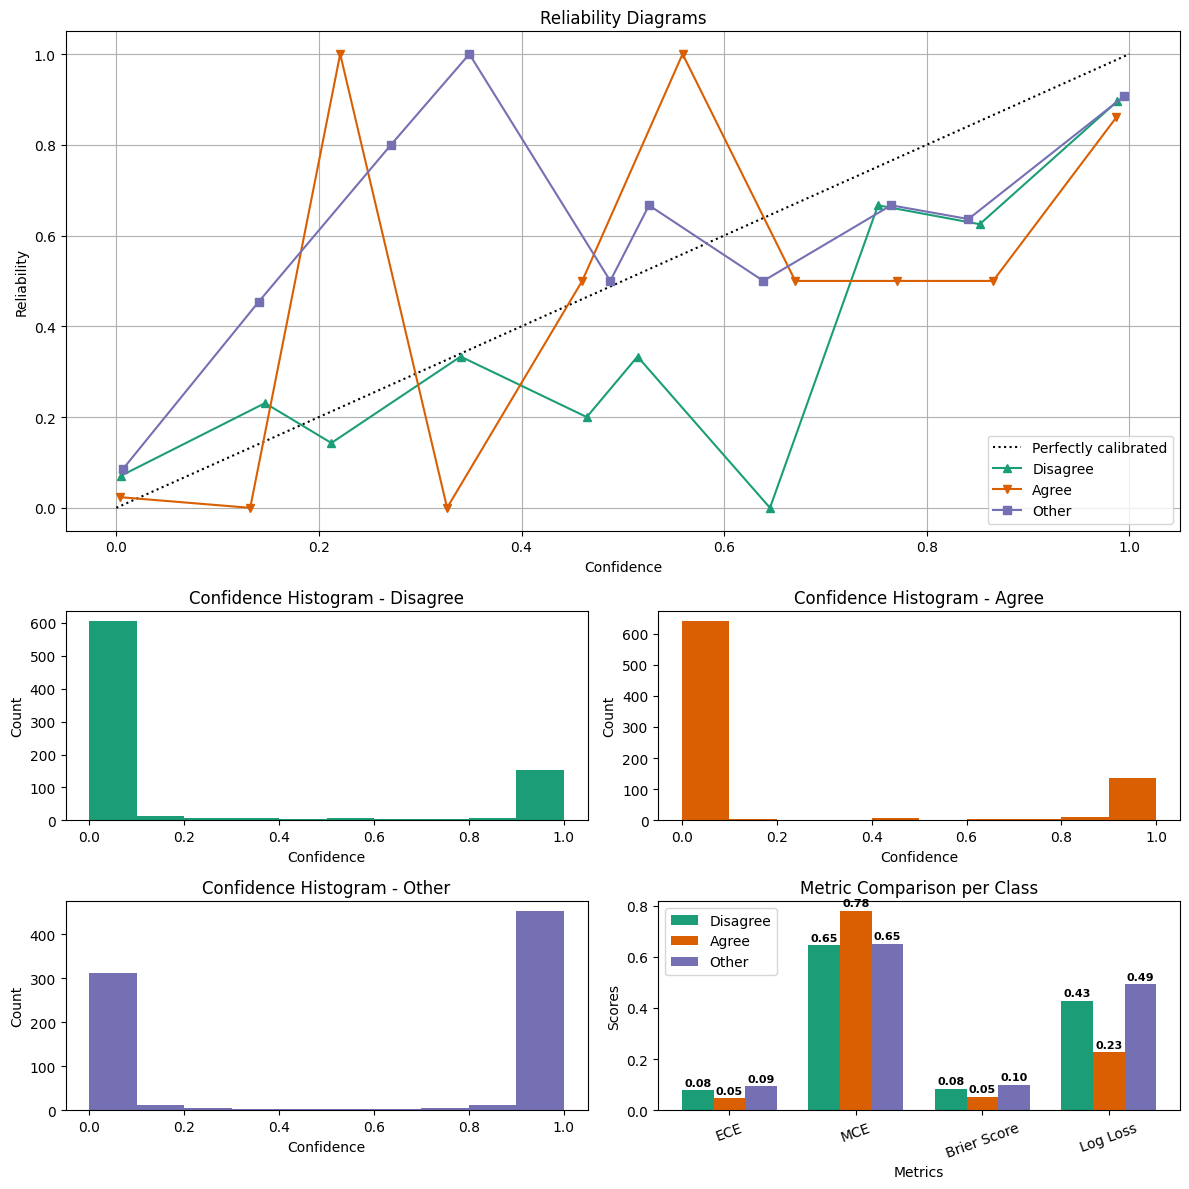

In [ ]:
class_names = {0: "Disagree", 1: "Agree", 2: "Other"}

# Call the function
plot_calibration_and_metrics(class_data, metrics_per_class, class_names)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

def plot_calibration_and_metrics(class_data, metrics_per_class, class_names):
    """
    Generates a visualization containing:
    - Calibration curves (Reliability diagrams) for different classes (reduced height)
    - Confidence histograms for probability distributions
    - A bar chart comparing evaluation metrics per class

    Parameters:
    - class_data: dict, {class_idx: {"y_true_binary": ..., "y_prob": ...}}
    - metrics_per_class: dict, {class_idx: {metric_name: value, ...}}
    - class_names: dict, {class_idx: "Class Name"}
    """

    # Initialize figure and grid layout
    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(4, 2, height_ratios=[1, 1, 1, 1])  # Adjust row heights
    colors = plt.get_cmap("Dark2")

    # Reduce reliability diagram height (occupies only row 0)
    ax_calibration_curve = fig.add_subplot(gs[0, :2])
    calibration_displays = {}

    # Define markers for different classes
    markers = ["^", "v", "s", "o"]

    # Calibration Curves
    for i, (class_idx, data) in enumerate(class_data.items()):
        y_true = data["y_true_binary"]
        y_prob = data["y_prob"]

        display = CalibrationDisplay.from_predictions(
            y_true,
            y_prob,
            n_bins=10,
            name=class_names.get(class_idx, f"Class {class_idx}"),
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i % len(markers)]
        )
        calibration_displays[class_idx] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Reliability Diagrams")
    ax_calibration_curve.set_xlabel("Confidence")
    ax_calibration_curve.set_ylabel("Reliability")

    # Histograms for Probability Distribution per Class
    grid_positions = [(1, 0), (1, 1), (2, 0)]  # Adjusted row positions

    for i, (class_idx, data) in enumerate(class_data.items()):
        if i >= len(grid_positions):
            break
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            data["y_prob"],
            range=(0, 1),
            bins=10,
            label=class_names.get(class_idx, f"Class {class_idx}"),
            color=colors(i),
        )
        ax.set(
            title=f"Confidence Histogram - {class_names.get(class_idx, f'Class {class_idx}')}",
            xlabel="Confidence",
            ylabel="Count"
        )

    # Add Bar Chart in (2,1)
    ax_bar = fig.add_subplot(gs[2, 1])

    # Extract metrics
    classes = list(metrics_per_class.keys())
    metrics = list(metrics_per_class[classes[0]].keys())
    values = np.array([[metrics_per_class[c][m] for m in metrics] for c in classes])
    class_labels = [class_names[c] for c in metrics_per_class.keys()]

    # Bar chart settings
    x = np.arange(len(metrics))  # Metric positions
    width = 0.25  # Bar width

    # Plot bars for each class
    for i, class_name in enumerate(class_labels):
        bars = ax_bar.bar(x + i * width, values[i], width, label=class_name, color=colors(i))

        # Add value labels on top of bars
        for bar in bars:
            yval = bar.get_height()
            ax_bar.text(
                bar.get_x() + bar.get_width() / 2,  # Centered on bar
                yval + 0.02,  # Slightly above the bar
                f"{yval:.2f}",  # Format to 2 decimal places
                ha="center", va="bottom", fontsize=10, fontweight="bold"
            )

    # Labels and title
    ax_bar.set_xlabel("Metrics")
    ax_bar.set_ylabel("Scores")
    ax_bar.set_title("Metric Comparison per Class")
    ax_bar.set_xticks(x + width)
    ax_bar.set_xticklabels(metrics, rotation=20)
    ax_bar.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()


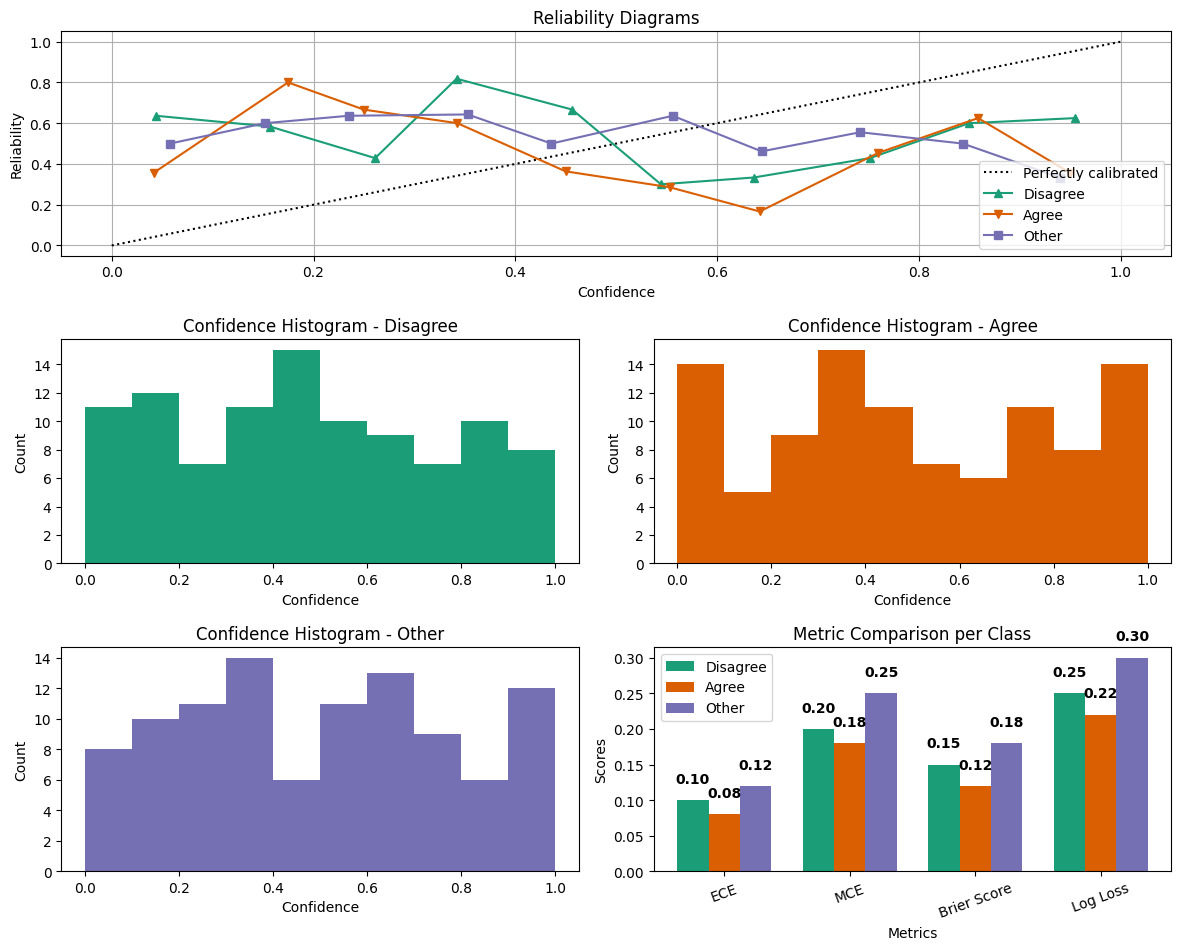

In [ ]:
# Example Inputs
class_data = {
    0: {"y_true_binary": np.random.randint(0, 2, 100), "y_prob": np.random.rand(100)},
    1: {"y_true_binary": np.random.randint(0, 2, 100), "y_prob": np.random.rand(100)},
    2: {"y_true_binary": np.random.randint(0, 2, 100), "y_prob": np.random.rand(100)}
}

metrics_per_class = {
    0: {"ECE": 0.1, "MCE": 0.2, "Brier Score": 0.15, "Log Loss": 0.25},
    1: {"ECE": 0.08, "MCE": 0.18, "Brier Score": 0.12, "Log Loss": 0.22},
    2: {"ECE": 0.12, "MCE": 0.25, "Brier Score": 0.18, "Log Loss": 0.3}
}

class_names = {0: "Disagree", 1: "Agree", 2: "Other"}

# Call the function
plot_calibration_and_metrics(class_data, metrics_per_class, class_names)